# __Activity 2__
## Rachel Nana, October 2018

__Importing Packages__

In [1]:
import pandas as pd
import sklearn
import numpy as np

__Importing Telco Data__

In [2]:
telco = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv');

__Data Prep__

producing indicators

In [3]:
Male_ind = telco['gender'].eq('Male').mul(1)
Partner_ind = telco['Partner'].eq('Yes').mul(1)
Dependents_ind = telco['Dependents'].eq('Yes').mul(1)
PhoneService_ind = telco['PhoneService'].eq('Yes').mul(1)
MultipleLines_ind = telco['MultipleLines'].eq('Yes').mul(1)
FiberOptic_ind = telco.rename(columns={'InternetService':'FiberOptic'})['FiberOptic'].eq('Fiber optic').mul(1)
DSL_ind = telco.rename(columns={'InternetService':'DSL'})['DSL'].eq('DSL').mul(1)
OnlineSecurity_ind = telco['OnlineSecurity'].eq('Yes').mul(1)
OnlineBackup_ind = telco['OnlineBackup'].eq('Yes').mul(1)
DeviceProtection_ind = telco['DeviceProtection'].eq('Yes').mul(1)
TechSupport_ind = telco['TechSupport'].eq('Yes').mul(1)
StreamingTV_ind = telco['StreamingTV'].eq('Yes').mul(1)
StreamingMovies_ind = telco['StreamingMovies'].eq('Yes').mul(1)
Contract_dummies=pd.get_dummies(telco['Contract'], drop_first=True)
PaperlessBilling_ind = telco['PaperlessBilling'].eq('Yes').mul(1)
PaymentMethod_dummies=pd.get_dummies(telco['PaymentMethod'], drop_first=True)
Churn_ind = telco['Churn'].eq('Yes').mul(1)

features

In [4]:
X = pd.concat([Male_ind, telco['SeniorCitizen'], Partner_ind, Dependents_ind, telco['tenure'], PhoneService_ind, MultipleLines_ind, FiberOptic_ind, DSL_ind, OnlineSecurity_ind, OnlineBackup_ind, DeviceProtection_ind, TechSupport_ind, StreamingTV_ind, StreamingMovies_ind, Contract_dummies, PaperlessBilling_ind, PaymentMethod_dummies, telco['MonthlyCharges'], telco['TotalCharges']], axis=1)
print(X[:5])
print(X.shape)

   gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0              0        1           0       1             0   
1       1              0        0           0      34             1   
2       1              0        0           0       2             1   
3       1              0        0           0      45             0   
4       0              0        0           0       2             1   

   MultipleLines  FiberOptic  DSL  OnlineSecurity      ...       StreamingTV  \
0              0           0    1               0      ...                 0   
1              0           0    1               1      ...                 0   
2              0           0    1               1      ...                 0   
3              0           0    1               1      ...                 0   
4              0           1    0               0      ...                 0   

   StreamingMovies  One year  Two year  PaperlessBilling  \
0                0         0    

encoding

In [5]:
from sklearn import preprocessing
for column in X.columns:
    if X[column].dtype == type(object):
        le = preprocessing.LabelEncoder()
        X[column] = le.fit_transform(X[column])

dependent variable

In [6]:
y = Churn_ind
print(y[:5])
print(y.shape)

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int32
(7043,)


split the data

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

feature scaling

In [8]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Hyperparameter Tuning

__Part 1: Base Model__

In [9]:
from sklearn.tree import DecisionTreeClassifier

train model

In [10]:
tree_base = DecisionTreeClassifier()
tree_base = tree_base.fit(X_train, y_train);

cross validation scores

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_roc_base = cross_val_score(tree_base, X_train, y_train, cv=10, scoring='roc_auc')
roc_score = np.mean(cross_val_roc_base)
print(roc_score)

0.64592119234


__Part 2: "Naive" Sweeps__

Testing criterion "gini" vs "entropy":

In [12]:
clf = DecisionTreeClassifier(criterion="gini")
cross_val_roc = cross_val_score(clf, X_train, y_train, cv=10, scoring='roc_auc')
roc_score = np.mean(cross_val_roc)
print(roc_score)

0.650461561099


In [13]:
clf = DecisionTreeClassifier(criterion="entropy")
cross_val_roc = cross_val_score(clf, X_train, y_train, cv=10, scoring='roc_auc')
roc_score = np.mean(cross_val_roc)
print(roc_score)

0.653442571699


_criterion = "entropy" performed slightly better._

Sweeping through max_depth param (values 1-20), where criterion="gini":

In [14]:
aucs = dict()

for i in range(1,20):
    clf = DecisionTreeClassifier(criterion="gini", max_depth=i)
    cross_val_roc = cross_val_score(clf, X_train, y_train, cv=10, scoring='roc_auc')
    roc_score = np.mean(cross_val_roc)
    aucs[i] = roc_score
    
print(aucs)

{1: 0.66856726721655779, 2: 0.75687267504668454, 3: 0.79715024113767141, 4: 0.8147684015275154, 5: 0.81449618492750786, 6: 0.80780631849285811, 7: 0.79921737820721717, 8: 0.77871591755658465, 9: 0.75498432815134431, 10: 0.72865844695454041, 11: 0.71257410028141965, 12: 0.69639959564277176, 13: 0.68884597509996026, 14: 0.67762855116399989, 15: 0.66577324053133058, 16: 0.65924129969121392, 17: 0.65357371197308278, 18: 0.65081177826926695, 19: 0.6519383013667831}


_When criterion = "gini", max_\__depth = 4 performed best._

Sweeping through max_depth param (values 1-20), where criterion="entropy":

In [15]:
aucs = dict()

for i in range(1,20):
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=i)
    cross_val_roc = cross_val_score(clf, X_train, y_train, cv=10, scoring='roc_auc')
    roc_score = np.mean(cross_val_roc)
    aucs[i] = roc_score
    
print(aucs)

{1: 0.64450094342518416, 2: 0.73942328866622975, 3: 0.79355063096899126, 4: 0.82166284787830546, 5: 0.82705891082848004, 6: 0.82822365472907045, 7: 0.81399340536572051, 8: 0.79764639851017716, 9: 0.77456954876027739, 10: 0.76235025185612248, 11: 0.74174285573763055, 12: 0.73087637933655358, 13: 0.7195711322177718, 14: 0.70510459954744376, 15: 0.69630447881047797, 16: 0.69637668496679939, 17: 0.68435520626122925, 18: 0.67384499212170312, 19: 0.66864617579353491}


_When criterion = "entropy", max_\__depth = 6 performed best._

Sweeping through min_samples_split (values 2-20), where criterion="entropy" and max_depth = 6:

In [16]:
aucs = dict()

for i in range(2,20):
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=6, min_samples_split=i)
    cross_val_roc = cross_val_score(clf, X_train, y_train, cv=10, scoring='roc_auc')
    roc_score = np.mean(cross_val_roc)
    aucs[i] = roc_score
    
print(aucs)

{2: 0.82783103472801689, 3: 0.82759516273112932, 4: 0.82835397333842875, 5: 0.8281466700172293, 6: 0.8281466700172293, 7: 0.827605761214526, 8: 0.82769917591702225, 9: 0.82798529987732139, 10: 0.82767618298164858, 11: 0.82751274884646464, 12: 0.82776228442168664, 13: 0.82759481329549511, 14: 0.82798529987732139, 15: 0.82825668132263064, 16: 0.82820173272291542, 17: 0.82834230009218768, 18: 0.82806605342263373, 19: 0.82815974651439039}


_When criterion = "entropy" and max_\__depth = 6, min_\__samples_\__split = 4 performed best._

__Part 3: RandomizedSearchCV__

In [17]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

parameter distribution from which the model will sample

In [18]:
param_dist_r = {"criterion": ["gini", "entropy"], 
              "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, None], 
              "max_features": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, None], 
              "max_leaf_nodes": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, None], 
              "min_samples_split": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 
              "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 
              "presort": ["True", "False"], 
              "splitter": ["best", "random"]}

train model

In [19]:
%%time
tree = DecisionTreeClassifier()
tree_rand_cv = RandomizedSearchCV(tree, param_dist_r, cv=10)
tree_rand_cv.fit(X_train,y_train);

Wall time: 1.08 s


print results

In [20]:
print("Tuned Decision Tree Parameters (Random Search): {}".format(tree_rand_cv.best_params_))

Tuned Decision Tree Parameters (Random Search): {'splitter': 'random', 'presort': 'False', 'min_samples_split': 14, 'min_samples_leaf': 10, 'max_leaf_nodes': 13, 'max_features': 15, 'max_depth': 17, 'criterion': 'gini'}


cross validation scores

In [21]:
cross_val_roc = cross_val_score(tree_rand_cv, X_train, y_train, cv=10, scoring='roc_auc')
roc_score = np.mean(cross_val_roc)
print(roc_score)

0.81525532978


__Part 4: GridSearchCV__

In [22]:
from sklearn.model_selection import GridSearchCV

parameter distribution from which the model will sample

In [23]:
param_dist_g = {"criterion": ["gini", "entropy"], 
              "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10, None], 
              "max_features": [2, 3, 4, 5, 6, 7, 8, 9, 10, None], 
              "max_leaf_nodes": [2, 3, 4, 5, 6, 7, 8, 9, 10, None], 
              "min_samples_split": [2, 3, 4, 5, 6, 7, 8, 9, 10],
              "min_samples_leaf": [2, 3, 4, 5, 6, 7, 8, 9, 10], 
              "presort": ["True", "False"], 
              "splitter": ["best", "random"]}

train model

In [24]:
%%time
tree_grid_cv = GridSearchCV(tree, param_dist_g, cv=10)
tree_grid_cv.fit(X_train,y_train);

Wall time: 19h 51min 44s


print results

In [25]:
print("Tuned Decision Tree Parameters (Grid Search): {}".format(tree_grid_cv.best_params_))

Tuned Decision Tree Parameters (Grid Search): {'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 10, 'min_samples_split': 5, 'presort': 'True', 'splitter': 'random'}


## Tree Visualization

__Part 1: Base Model__

Visualize

In [26]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data1 = StringIO()
export_graphviz(tree_base, out_file=dot_data1, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data1.getvalue())  
Image(graph.create_png())

graph.write_pdf("decision_tree_base_model.pdf")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.610357 to fit



True

__Part 2: "Naive" Sweeps__

Train Model

In [27]:
tree_naive = DecisionTreeClassifier(criterion="entropy", max_depth=6, min_samples_split=4)
tree_naive = tree_naive.fit(X_train, y_train)

Visualize

In [28]:
dot_data2 = StringIO()
export_graphviz(tree_naive, out_file=dot_data2, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data2.getvalue())  
Image(graph.create_png())

graph.write_pdf("decision_tree_naive_sweeps.pdf")

True

__Part 3: Random Search__

Train Model

In [29]:
tree_rand = DecisionTreeClassifier(criterion="gini", max_depth=17, max_features=15, max_leaf_nodes=13, min_samples_leaf=10, 
                                   min_samples_split=14, presort="False", splitter="random")
tree_rand = tree_rand.fit(X_train, y_train)

Visualize

In [30]:
dot_data3 = StringIO()
export_graphviz(tree_rand, out_file=dot_data3, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data3.getvalue())  
Image(graph.create_png())

graph.write_pdf("decision_tree_random_search.pdf")

True

__Part 4: Grid Search__

Train Model

In [31]:
tree_grid = DecisionTreeClassifier(criterion="gini", max_depth=7, max_features=None, max_leaf_nodes=None, min_samples_leaf=10, 
                                   min_samples_split=5, presort="True", splitter="random")
tree_grid = tree_grid.fit(X_train, y_train)

Visualize

In [32]:
dot_data4 = StringIO()
export_graphviz(tree_grid, out_file=dot_data4, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data4.getvalue())  
Image(graph.create_png())

graph.write_pdf("decision_tree_grid_search.pdf")

True

## ROC Curves

__Part 1: Base Model__

Predictions

In [33]:
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot as plt

predictions1 = tree_base.predict_proba(X_test)
roc_score_base = roc_auc_score(y_test, predictions1[:,1])
print(roc_score_base)

0.636694287163


ROC curve

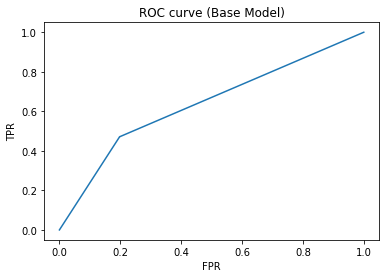

In [34]:
fpr1, tpr1, _ = roc_curve(y_test, predictions1[:,1])
plt.plot(fpr1, tpr1)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve (Base Model)')
plt.show()

__Part 2: "Naive" Sweeps__

Predictions

In [35]:
predictions2 = tree_naive.predict_proba(X_test)
roc_score_naive = roc_auc_score(y_test, predictions2[:,1])
print(roc_score_naive)

0.842136180608


ROC curve

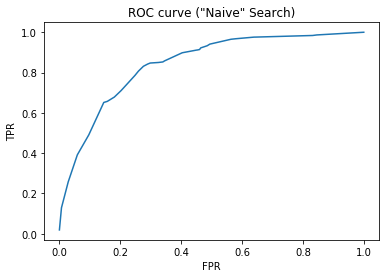

In [36]:
fpr2, tpr2, _ = roc_curve(y_test, predictions2[:,1])
plt.plot(fpr2, tpr2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve ("Naive" Search)')
plt.show()

__Part 3: Random Search__

Predictions

In [37]:
predictions3 = tree_rand.predict_proba(X_test)
roc_score_rand = roc_auc_score(y_test, predictions3[:,1])
print(roc_score_rand)

0.82792913557


ROC curve

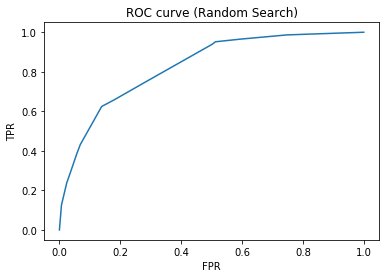

In [38]:
fpr3, tpr3, _ = roc_curve(y_test, predictions3[:,1])
plt.plot(fpr3, tpr3)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve (Random Search)')
plt.show()

__Part 4: Grid Search__

Predictions

In [39]:
predictions4 = tree_grid.predict_proba(X_test)
roc_score_grid = roc_auc_score(y_test, predictions4[:,1])
print(roc_score_grid)

0.840787934622


ROC curve

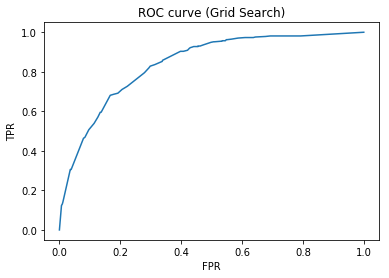

In [40]:
fpr4, tpr4, _ = roc_curve(y_test, predictions4[:,1])
plt.plot(fpr4, tpr4)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve (Grid Search)')
plt.show()

__Combined__

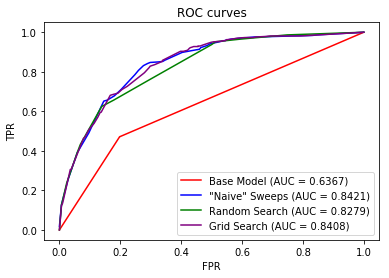

In [42]:
f = plt.figure()
plt.plot(fpr1, tpr1, color='red', label='Base Model (AUC = %0.4f)' % roc_score_base)
plt.plot(fpr2, tpr2, color='blue', label='"Naive" Sweeps (AUC = %0.4f)' % roc_score_naive)
plt.plot(fpr3, tpr3, color='green', label='Random Search (AUC = %0.4f)' % roc_score_rand)
plt.plot(fpr4, tpr4, color='purple', label='Grid Search (AUC = %0.4f)' % roc_score_grid)
plt.legend(loc="lower right")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curves')
plt.show()

f.savefig("ROC_curves.pdf", bbox_inches='tight')